<div style="background: linear-gradient(135deg, #034694 0%, #1E8449 50%, #D4AC0D 100%); color: white; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.2);">
    <h1 style="color: #FFF; text-shadow: 1px 1px 3px rgba(0,0,0,0.5);">💬 | Step 3: Be More Cost-Effective With Distillation </h1>
        <p style="font-size: 16px; line-height: 1.6;">
            We have the model customized to provide the right tone and style. But we are using a large (slow and expensive) model for a very narrow and focused task. Let's see how we can distill the knowledge to a smaller (faster and cheaper) model to get comparable accuracy with better efficiency - by trading in general-purpose LLMs for a narrower task-specific intelligence.
        </p>
</div>

---

## 1. Check Environment Setup



In [1]:
# First, make sure required environment variables are set
import os

openai_key = os.getenv("AZURE_OPENAI_API_KEY")
openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model_name = "gpt-4.1"
api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2025-02-01-preview")

if not openai_key or not openai_endpoint:
    print("Error: Missing AZURE_OPENAI_KEY or AZURE_OPENAI_ENDPOINT environment variable.")

print("Using Model:", model_name)
print("Using API Version:", api_version)

Using Model: gpt-4.1
Using API Version: 2025-02-01-preview


In [2]:
# Then create an Azure OpenAI Client instance
from openai import AzureOpenAI

client = AzureOpenAI(
    azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),
    api_key=os.environ.get("AZURE_OPENAI_API_KEY"),
    api_version="2025-04-01-preview",
)

In [3]:
# And create a handy UUID we can use to track each run of this notebook
import uuid
UNIQUE_ENOUGH_KEY = str(uuid.uuid4()).split("-")[0]

---

## 2. Distillation From Teacher

### 2.1 Find Our Winning Model

In [4]:
import json
from openai import AzureOpenAI

# Load exported data from grader notebook
with open('32-distillation_export.json', 'r') as f:
    export_data = json.load(f)

# Reconstruct the baseline runs
baseline_eval_id = export_data['baseline_eval_id']
baseline_runs = []

for i, run_id in enumerate(export_data['baseline_runs_ids']):
    run = client.evals.runs.retrieve(eval_id=baseline_eval_id, run_id=run_id)
    run.model = export_data['baseline_runs_models'][i]  # Ensure model name is set
    baseline_runs.append(run)

# Get other variables
baseline_eval = client.evals.retrieve(baseline_eval_id)
qa_validation = export_data['qa_validation']
GRADER_MODEL = export_data['GRADER_MODEL']
GRADER_PROMPT = export_data['GRADER_PROMPT'] 
SYSTEM_PROMPT = export_data['SYSTEM_PROMPT']

print(f"✅ Loaded {len(baseline_runs)} baseline runs from grader notebook")
print(f"✅ Loaded {len(qa_validation)} validation Q&A pairs")

✅ Loaded 5 baseline runs from grader notebook
✅ Loaded 153 validation Q&A pairs


In [5]:
# Composite metric based teacher/student selection
# Uses existing score_distribution + HIGH_SCORES already populated above

import math
from statistics import mean

CUTOFF = 4.0
HIGH_SCORES = {
    "gpt-4o": [],
    "gpt-4.1": [],
    "o3-mini": [],
    "o4-mini": [],
    "gpt-4o-mini": [],
    "gpt-4.1-nano": [],
}

# Let's find our responses that were Excellent (at or above CUTOFF). We'll collect them
# and pre-format them into chat completions format to save time later.
#
# This part is honestly a bit tricky...we're extracting the prompts and responses for the
# model under test and *not* the prompts to the grader, so we have to do surgery. 🔪
for run in baseline_runs:
    pages = client.evals.runs.output_items.list(run.id, eval_id=baseline_eval.id).iter_pages()
    for page in pages:
        for item in page.data:
            # We only used 1 grader. If you use multiple, you should look for which ones you want.
            if not item.results:
                continue
            result = item.results[0]
            # FIX: Use attribute access for score and sample
            if result.score >= CUTOFF:
                generated = result.sample["input"][-1]["content"].strip().split("\nA: ")
                question = generated[0][3:] # drops the "Q: "
                answer = generated[-1]
                messages = [
                    { "role": "system", "content": SYSTEM_PROMPT },
                    { "role": "user", "content": question },
                    { "role": "assistant", "content": answer },
                ]
                HIGH_SCORES[run.model].append({ "messages": messages })

# 1. Collect raw score lists for each model (recompute if needed)
score_distribution = {}
for run in baseline_runs:
    score_distribution.setdefault(run.model, [])
    pages = client.evals.runs.output_items.list(run.id, eval_id=baseline_eval.id).iter_pages()
    for page in pages:
        for item in page.data:
            if not item.results:
                continue
            result = item.results[0]
            # FIX: Use attribute access for score
            if hasattr(result, "score"):
                score_distribution[run.model].append(result.score)

# 2. Define model size ordering (left = larger / more capable)
SIZE_ORDER = ["o3-mini", "gpt-4.1", "o4-mini", "gpt-4o-mini", "gpt-4.1-nano"]
SIZE_INDEX = {m:i for i,m in enumerate(SIZE_ORDER)}

# 3. Composite quality metric
#    quality = 0.5*mean + 0.3*p90 + 0.2*coverage  (coverage scaled to 0-10)
#    p90 stabilizes performance tail; coverage rewards consistency

def composite_quality(scores, cutoff):
    if not scores:
        return -1
    scores_sorted = sorted(scores)
    p90 = scores_sorted[math.floor(0.9*(len(scores_sorted)-1))]
    coverage = sum(1 for s in scores if s >= cutoff) / len(scores) if scores else 0.0
    return 0.5*mean(scores) + 0.3*p90 + 0.2*(coverage*10)  # coverage scaled

# 4. Pick teacher = argmax composite_quality (ties broken by larger model first)
cutoff = CUTOFF  # reuse existing threshold
model_metrics = []
for model, scores in score_distribution.items():
    cq = composite_quality(scores, cutoff)
    model_metrics.append({
        "model": model,
        "mean": round(mean(scores),2) if scores else 0,
        "p90": round(sorted(scores)[math.floor(0.9*(len(scores)-1))],2) if scores else 0,
        "coverage": round(sum(1 for s in scores if s >= cutoff)/len(scores),2) if scores else 0,
        "high_scores": len([s for s in scores if s >= cutoff]),
        "n": len(scores),
        "composite": round(cq,3),
        "size_index": SIZE_INDEX.get(model, 999)
    })

# Sort for display
model_metrics.sort(key=lambda d: d['composite'], reverse=True)
TEACHER_MODEL = model_metrics[0]['model'] if model_metrics else None

# 5. Student selection: choose smallest model with >= MIN_STUDENT_SAMPLES high scores
MIN_STUDENT_SAMPLES = 10

eligible_students = []
for m in HIGH_SCORES:
    if m == TEACHER_MODEL:
        continue
    if m not in SIZE_INDEX or TEACHER_MODEL not in SIZE_INDEX:
        continue
    if SIZE_INDEX[m] <= SIZE_INDEX[TEACHER_MODEL]:  # must be strictly smaller
        continue
    high_count = len(HIGH_SCORES[m])
    if high_count >= MIN_STUDENT_SAMPLES:
        eligible_students.append((m, high_count))

if eligible_students:
    # Prefer smallest (highest size index), tie-break by more high samples
    eligible_students.sort(key=lambda t: (SIZE_INDEX[t[0]], -t[1]))
    STUDENT_MODEL = eligible_students[-1][0]
else:
    # Relax: pick smallest model with ANY high scores, else default nano
    relaxed = [(m, len(HIGH_SCORES[m])) for m in HIGH_SCORES 
               if m != TEACHER_MODEL and m in SIZE_INDEX and SIZE_INDEX[m] > SIZE_INDEX[TEACHER_MODEL] and len(HIGH_SCORES[m]) > 0]
    if relaxed:
        relaxed.sort(key=lambda t: (SIZE_INDEX[t[0]], -t[1]))
        STUDENT_MODEL = relaxed[-1][0]
    else:
        STUDENT_MODEL = "gpt-4.1-nano"

print("=== Model Composite Metrics ===")
for mm in model_metrics:
    star = "<- TEACHER" if mm['model'] == TEACHER_MODEL else ""
    print(f"{mm['model']:12s} comp={mm['composite']:5.2f} mean={mm['mean']:4.2f} p90={mm['p90']:4.2f} cov={mm['coverage']:4.2f} hi={mm['high_scores']:3d}/{mm['n']:3d} {star}")

print(f"\nSelected Teacher: {TEACHER_MODEL}")
print(f"Selected Student: {STUDENT_MODEL} (high samples: {len(HIGH_SCORES[STUDENT_MODEL])})")

# 6. (Optional) Raise cutoff adaptively if too many highs (all models >90% coverage)
if all(mm['coverage'] > 0.9 for mm in model_metrics if mm['n'] > 0):
    print("⚠️ Coverage very high across all models — consider increasing CUTOFF to better separate quality.")


=== Model Composite Metrics ===
o3-mini      comp= 7.71 mean=6.62 p90=8.00 cov=1.00 hi=135/135 <- TEACHER
o4-mini      comp= 6.71 mean=4.62 p90=8.00 cov=1.00 hi=130/130 
gpt-4.1-nano comp= 5.84 mean=4.29 p90=6.00 cov=0.95 hi=129/136 
gpt-4o-mini  comp= 5.14 mean=4.06 p90=4.00 cov=0.96 hi=131/137 
gpt-4o       comp= 5.07 mean=3.94 p90=4.00 cov=0.95 hi=133/140 

Selected Teacher: o3-mini
Selected Student: gpt-4.1-nano (high samples: 129)
⚠️ Coverage very high across all models — consider increasing CUTOFF to better separate quality.


### 2.2 Create Our Training Datasets

In [6]:
# Before we go any further, let's turn our collected excellent responses into our
# training and validation fine-tuning datasets. Like before, we have to write these
# to disk and then upload them via the Files API.
training_filename = f"zava-tone-training-{UNIQUE_ENOUGH_KEY}.jsonl"
validation_filename = f"zava-tone-validation-{UNIQUE_ENOUGH_KEY}.jsonl"

# Make an 80/20 split to form our training/validation data.
split_at = int(len(HIGH_SCORES[TEACHER_MODEL]) * 0.80)
training_data = HIGH_SCORES[TEACHER_MODEL][:split_at]
validation_data = HIGH_SCORES[TEACHER_MODEL][split_at:]
print(f"Split into {len(training_data)} training / {len(validation_data)} validation rows.")

# Create and upload the training data.
with open(training_filename, "w") as f:
    for message in training_data:
        json.dump(message, f)
        f.write("\n")
with open(training_filename, "rb") as f:
    training_file = client.files.create(file=f, purpose="fine-tune")
    training_file = client.files.wait_for_processing(training_file.id)
print(f"🏋️‍♂️ Created training file:\n{training_file.to_json(indent=2)}")

# Create and upload the validation data.
with open(validation_filename, "w") as f:
    for message in validation_data:
        json.dump(message, f)
        f.write("\n")
with open(validation_filename, "rb") as f:
    validation_file = client.files.create(file=f, purpose="fine-tune")
    validation_file = client.files.wait_for_processing(validation_file.id)
print(f"📋 Created validation file:\n{validation_file.to_json(indent=2)}")

Split into 108 training / 27 validation rows.


🏋️‍♂️ Created training file:
{
  "id": "file-a6f119dd59844f8ebe435eb0bae90491",
  "bytes": 262457,
  "created_at": 1762436288,
  "filename": "zava-tone-training-7c3d1b4a.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}
📋 Created validation file:
{
  "id": "file-8fb85b60901d48b9bb0469a5ab1e8d82",
  "bytes": 58427,
  "created_at": 1762436294,
  "filename": "zava-tone-validation-7c3d1b4a.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}


### 2.3 Training The Student

In [7]:
# Now we start training! Submit our fine-tuning job to teach 4.1-nano new tricks.
## NN-TOFIX: Check STUDENT MODEL name
TEACHER_MODEL = TEACHER_MODEL
STUDENT_MODEL = STUDENT_MODEL
SUFFIX = f"{TEACHER_MODEL}-zava-tone-{UNIQUE_ENOUGH_KEY}".replace(".", "") # '.' is a reserved character 😜

# OPTIMIZATION 4: Optimized hyperparameters for faster convergence
job = client.fine_tuning.jobs.create(
    model=STUDENT_MODEL,
    suffix=SUFFIX,
    training_file=training_file.id,
    validation_file=validation_file.id,
    extra_body={ "trainingType": "globalstandard" },
)
print(f"👨‍🔬 Created fine-tuning job:\n{job.to_json(indent=2)}")

👨‍🔬 Created fine-tuning job:
{
  "id": "ftjob-78c3fc0340e547dc8a82fb5c161d0fab",
  "created_at": 1762436299,
  "hyperparameters": {
    "batch_size": -1,
    "learning_rate_multiplier": 0.1,
    "n_epochs": -1
  },
  "model": "gpt-4.1-nano-2025-04-14",
  "object": "fine_tuning.job",
  "seed": 282718720,
  "status": "pending",
  "training_file": "file-a6f119dd59844f8ebe435eb0bae90491",
  "validation_file": "file-8fb85b60901d48b9bb0469a5ab1e8d82",
  "estimated_finish": 1762441449,
  "suffix": "o3-mini-zava-tone-7c3d1b4a",
  "trainingType": "globalStandard"
}


### 2.4 Wait For Fine Tuning Job

In [8]:
# OPTIMIZATION 1: Add early stopping and progress monitoring to speed up training
from IPython.display import clear_output
import time

start_time = time.time()
last_loss = None
patience_counter = 0
PATIENCE = 3  # Stop if no improvement for 3 checks

status = job.status
while status not in ["succeeded", "failed", "cancelled"]:
    time.sleep(10)
    job = client.fine_tuning.jobs.retrieve(job.id)
    status = job.status
    
    # OPTIMIZATION 2: Monitor training metrics for early stopping
    try:
        events = client.fine_tuning.jobs.list_events(job.id, limit=5)
        if events.data:
            latest_event = events.data[0]
            if hasattr(latest_event, 'data') and 'train_loss' in latest_event.data:
                current_loss = latest_event.data['train_loss']
                if last_loss and current_loss >= last_loss:
                    patience_counter += 1
                    if patience_counter >= PATIENCE:
                        print(f"⚠️ Early stopping: Loss plateau detected")
                        # Could implement job cancellation here if needed
                else:
                    patience_counter = 0
                last_loss = current_loss
                print(f"📈 Latest train_loss: {current_loss:.4f}")
    except Exception as e:
        pass  # Continue without early stopping if events unavailable
    
    clear_output(wait=True)
    print(f"👨‍🔬 Job {job.id}: {status}")
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

if status == "succeeded":
    print(f"🏁 Fine-tuning finished!")
else:
    raise RuntimeError(f"Fine-tuning job did not complete successfully (status={status})")

👨‍🔬 Job ftjob-78c3fc0340e547dc8a82fb5c161d0fab: succeeded
⏱️ Elapsed time: 66 minutes 14 seconds
🏁 Fine-tuning finished!


---

## 3. Judging The Distilled Student

### 3.1 Deploy Fine-Tuned Model

In [9]:
# Now we need to deploy our fine-tuned model. We'll use Developer Tier to keep
# costs under control for evaluation.

# We can't do this with the OpenAI SDK, so we need to reach for the Azure SDK.
from azure.identity import DefaultAzureCredential
from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient

cogsvc_client = CognitiveServicesManagementClient(
    credential=DefaultAzureCredential(),
    subscription_id=os.environ.get("AZURE_SUBSCRIPTION_ID")
)

# Define our Deployment. Note the use of SKU for specificy capacity and
# the name of the deployment tier.
DEPLOYMENT_NAME = f"zava-tone-distilled-{SUFFIX}"
DEPLOYMENT = {
    "properties": {
        "model": { 
            "format": "OpenAI", 
            "name": job.fine_tuned_model, 
            "version": "1" 
        },
    },
    "sku": { 
        "capacity": 250, 
        "name": "DeveloperTier" 
    },
}

# Submit the request for provisioning. This may take a few minutes, so we
# poll for updates. If it already exists, this should return quickly. Since
# we're deploying a 4.1-nano model, this should only take 3-5 minutes tops.
deployment = cogsvc_client.deployments.begin_create_or_update(
    resource_group_name=os.environ.get("AZURE_RESOURCE_GROUP"),
    account_name=os.environ.get("AZURE_AI_FOUNDRY_NAME"),
    deployment_name=DEPLOYMENT_NAME,
    deployment=DEPLOYMENT,
)
print(f"🛳️ Submitted deployment {deployment}")

🛳️ Submitted deployment <azure.core.polling._poller.LROPoller object at 0x7d9c2171ab10>


### 3.2 Wait Till Deployment Ready

In [10]:
# Wait for our deployment to finish provisioning.
from IPython.display import clear_output
import time

start_time = time.time()
status = deployment.status()

while status not in ["Succeeded", "Failed"]:
    deployment.wait(5)
    status = deployment.status()
    clear_output(wait=True)
    print(f"🛳️ Provisioning {DEPLOYMENT_NAME}: {status}")
    print("⏱️Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

print(f"🏁 Provisioning finished!")


🛳️ Provisioning zava-tone-distilled-o3-mini-zava-tone-7c3d1b4a: Succeeded
⏱️Elapsed time: 4 minutes 32 seconds
🏁 Provisioning finished!


### 3.3 Upload Validation Data

In [11]:
# Now we'll upload our post-training validation dataset and prepare our final Evaluation.
# We need to save the data to disk first, again for...reasons.
filename = f"./zava-tone-posttraining-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_validation:
        json.dump(row, f)
        f.write("\n")

posttraining_file = None
with open(filename, "rb") as f:
    posttraining_file = client.files.create(purpose="evals", file=f)
    posttraining_file = client.files.wait_for_processing(posttraining_file.id)

### 3.4 Evaluate Student vs. Peers

In [12]:
# Now we define our Evaluation for validating our choice in grader prompt and model.

# The entire user prompt is data driven from the file. No generation is done using
# a model in this case, just simple string substitution using this pattern. This
# means we directly reference the two fields in our baseline.jsonl file.

USER_PROMPT = """
Q: {{item.question}}
A: {{item.answer}}
"""

INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# We need to describe what our evaluation dataset looks like.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    }
}
DATA_SOURCE = {
    "item_schema": SCHEMA,
    "include_sample_schema": False,
    "type": "custom",
}

# Lastly, we define test criteria that combines all the above.
TESTING_CRITERIA = {
    "name": "Zava Tone Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],    # Our grader scores in a range from 1 to 10
    "pass_threshold": 4.0,   # Let's say a 4 is "passing" for now.
}

In [13]:
# Now we create a final Eval using our post-training dataset that doesn't overlap with the
# original distillation and training dataset. This lets us judge our new model based on
# data it hasn't seen before. We'll also through in one of our better performing base
# models as a control.
POST_EVAL_MODELS = [
    DEPLOYMENT_NAME,# distilled
    "gpt-4.1-nano", # student
    "gpt-4.1",      # control
]

# SCHEMA, GRADER_MODEL, and INPUT are re-used from our previous Evaluation definition,
# but let's restate the source and testing criteria again.
DATA_SOURCE = {
    "item_schema": SCHEMA, 
    "include_sample_schema": True, # Note this change! Needed for data gen.
    "type": "custom"
}
# OPTIMIZATION 3: Multi-grader validation to reduce bias
TESTING_CRITERIA = [
    {
        "name": "Zava Tone Grader (Primary)",
        "type": "score_model", 
        "model": GRADER_MODEL,
        "input": INPUT,
        "range": [1.0, 10.0],
        "pass_threshold": 4.0,
    },
    {
        "name": "Consistency Check (Secondary)",
        "type": "score_model",
        "model": "gpt-4o",  # Different model for cross-validation
        "input": INPUT,
        "range": [1.0, 10.0], 
        "pass_threshold": 4.0,
    }
]
posttraining_eval = client.evals.create(
    name=f"zava-tone-posttrain-evaluation-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=TESTING_CRITERIA  # Now using list of criteria
)
print(f"Created eval {posttraining_eval.id}")

# Now add our runs.
postraining_runs = []
for model in POST_EVAL_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": { "type": "file_id", "id": posttraining_file.id },
        "input_messages": {
            "type": "template",
            "template": [
                { 
                    "type": "message", 
                    "role": "system", 
                    "content": { "type": "input_text", "text": SYSTEM_PROMPT },
                },
                { 
                    "type": "message", 
                    "role": "user", 
                    "content": { "type": "input_text", "text": "{{item.question}}" },
                },
            ],
        },
        "sampling_params": { "max_completions_tokens": 100 }, # XXX again, note the purposeful typo
    }
    run = client.evals.runs.create(
        name=f"{model}-{UNIQUE_ENOUGH_KEY}", 
        eval_id=posttraining_eval.id,
        data_source=RUN_DATA_SOURCE, 
    )
    print(f"🏃‍➡️ Created run {run.id} for {posttraining_eval.id}")
    postraining_runs.append(run)


Created eval eval_690cb566eba0819194dd096ea6a8a9e8
🏃‍➡️ Created run evalrun_690cb56792c4819192d5e82350192a5a for eval_690cb566eba0819194dd096ea6a8a9e8
🏃‍➡️ Created run evalrun_690cb568491c8191a7f802b34000889b for eval_690cb566eba0819194dd096ea6a8a9e8
🏃‍➡️ Created run evalrun_690cb568cfd081918f46d74bea43b0a4 for eval_690cb566eba0819194dd096ea6a8a9e8


### 3.5 Wait For Evaluations

In [14]:
# Again, we wait for our runs to finish.
start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in postraining_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(postraining_runs)):
        postraining_runs[i] = client.evals.runs.retrieve(eval_id=posttraining_eval.id, run_id=postraining_runs[i].id)
        print(f"🏃‍➡️ Run {postraining_runs[i].name}: {postraining_runs[i].status}")
    
    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(postraining_runs)} runs completed!")

🏃‍➡️ Run zava-tone-distilled-o3-mini-zava-tone-7c3d1b4a-7c3d1b4a: completed
🏃‍➡️ Run gpt-4.1-nano-7c3d1b4a: completed
🏃‍➡️ Run gpt-4.1-7c3d1b4a: completed
⏱️ Elapsed time: 7 minutes 25 seconds
🏁 All 3 runs completed!


---

## 4. Interpret The Results

Get Evaluation Runs: eval_690cb566eba0819194dd096ea6a8a9e8

Combined Evaluation Summary
                                  Run ID                                                Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                         Evaluation Name
evalrun_690cb56792c4819192d5e82350192a5a zava-tone-distilled-o3-mini-zava-tone-7c3d1b4a-7c3d1b4a zava-tone-disti completed           80.272109             3.921569 eval_690cb566eba0819194dd096ea6a8a9e8 zava-tone-posttrain-evaluation-7c3d1b4a
evalrun_690cb568cfd081918f46d74bea43b0a4                                        gpt-4.1-7c3d1b4a         gpt-4.1 completed           79.738562             0.000000 eval_690cb566eba0819194dd096ea6a8a9e8 zava-tone-posttrain-evaluation-7c3d1b4a
evalrun_690cb568491c8191a7f802b34000889b                                   gpt-4.1-nano-7c3d1b4a    gpt-4.1-nano completed           72.549020             0.000000 eval_690cb566eba081919

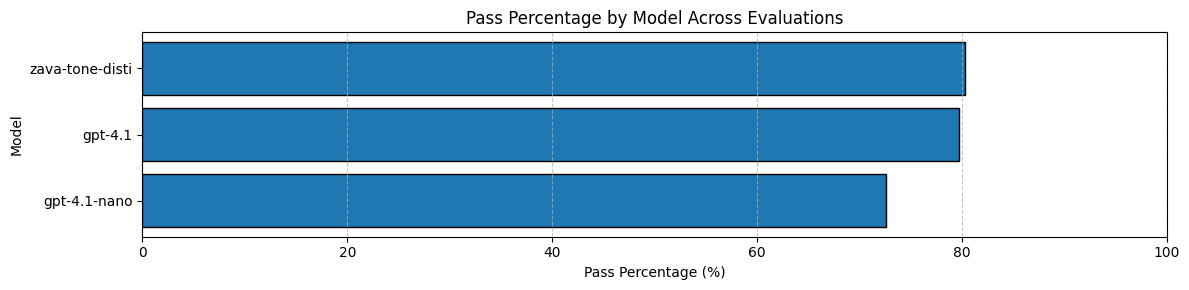

Fetching scores...

Score Summary Table:
          Model                         Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
zava-tone-disti zava-tone-posttrain-evaluation-7c3d1b4a          4.85      1.00     10.00            4.00            4.00            4.00            6.00            8.00
        gpt-4.1 zava-tone-posttrain-evaluation-7c3d1b4a          4.85      1.00     10.00            2.80            4.00            4.00            6.00            8.00
   gpt-4.1-nano zava-tone-posttrain-evaluation-7c3d1b4a          4.71      1.00     10.00            1.00            4.00            4.00            6.00            8.00


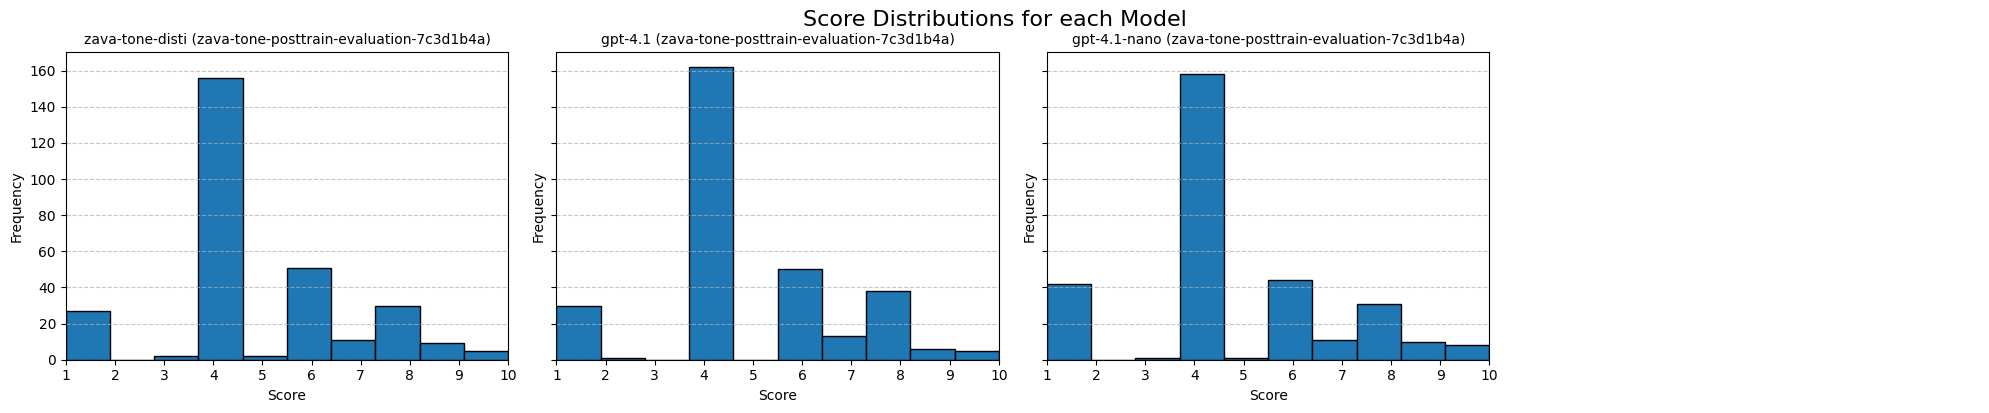

In [15]:
import importlib.util
spec = importlib.util.spec_from_file_location("eval_utils", "eval_utils.py")
eval_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(eval_utils)
display_evaluation_summary = eval_utils.display_evaluation_summary

display_evaluation_summary(client, [posttraining_eval.id], x_range=(1, 10))

Get Evaluation Runs: eval_690ca0f6d3ac8191ad424fe445c5bfff
Get Evaluation Runs: eval_690cb566eba0819194dd096ea6a8a9e8

Combined Evaluation Summary
                                  Run ID                                                Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                         Evaluation Name
evalrun_690ca0f862f081918025e4f8c17a308b                                        o4-mini-3381c716         o4-mini completed          100.000000             0.000000 eval_690ca0f6d3ac8191ad424fe445c5bfff          32-zava-tone-baseline-3381c716
evalrun_690ca0f751b481918e453bc5fb8823e6                                        o3-mini-3381c716         o3-mini completed          100.000000             3.267974 eval_690ca0f6d3ac8191ad424fe445c5bfff          32-zava-tone-baseline-3381c716
evalrun_690ca0faeab08191a9d44a12f4ad0451                                    gpt-4o-mini-3381c716     gpt-4o-mini completed     

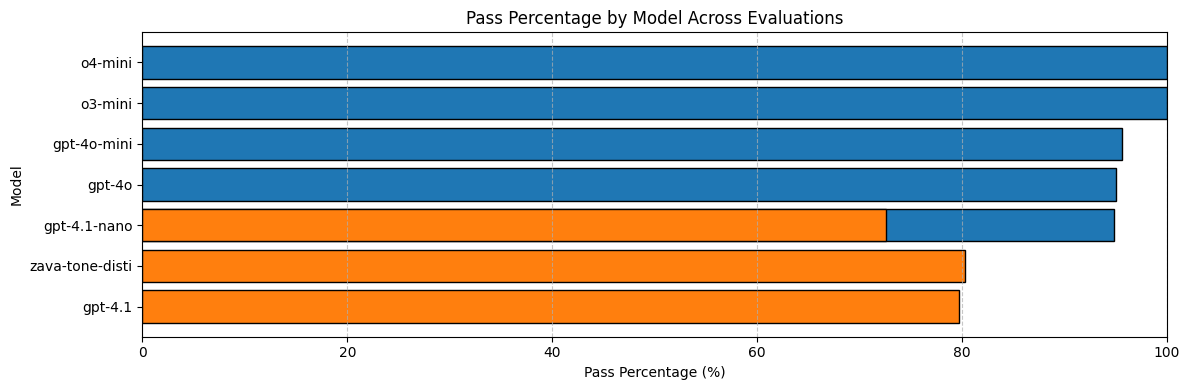

Fetching scores...

Score Summary Table:
          Model                         Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
        o3-mini          32-zava-tone-baseline-3381c716          6.62      4.00     10.00            4.00            6.00            6.00            8.00            8.00
        o4-mini          32-zava-tone-baseline-3381c716          4.62      4.00      8.00            4.00            4.00            4.00            4.00            8.00
   gpt-4.1-nano          32-zava-tone-baseline-3381c716          4.29      1.00     10.00            4.00            4.00            4.00            4.00            6.00
    gpt-4o-mini          32-zava-tone-baseline-3381c716          4.06      1.00      8.00            4.00            4.00            4.00            4.00            4.00
         gpt-4o          32-zava-tone-baseline-3381c716          3.94      1.00      8.00            4.00    

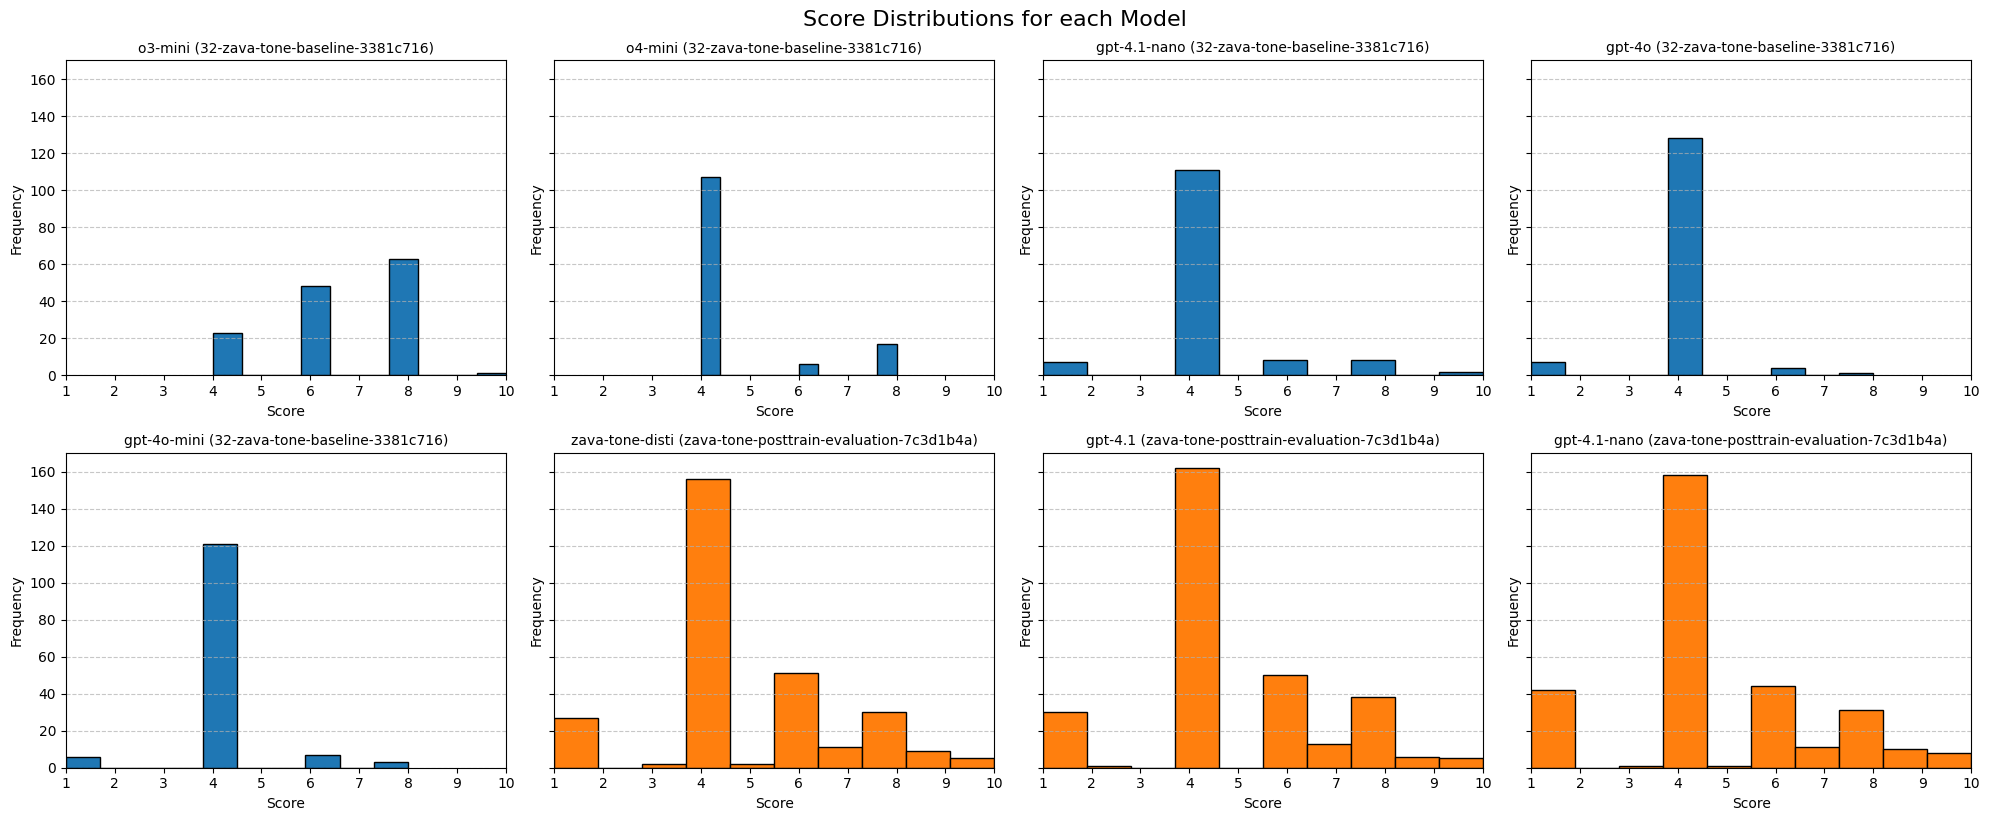

In [16]:
# And now let's put it all together.
# Let's visualize our post-training evaluation. Fingers crossed!
display_evaluation_summary(client, [baseline_eval.id, posttraining_eval.id], x_range=(1, 10))

---

## 5. Teardown

Don't forget to clean up - delete the resource group, purge resources!

---

## 6. Summary 

In this notebook we demonstrated **distillation** using Azure OpenAI *Evaluations*
and *Fine Tuning* features.

We used an objective of *adjusting the tone* of a model to meet our needs, in this
case making its responses sarcastic, while preserving accuracy in results, and
*distilled* the native capabilities of a state-of-the-art reasoning model (`o3-mini`)
into a much smaller, non-reasoning model (`4.1-nano`) to let our agent or app
use the smallest model possible while:

- 🤑 minimizing per-token costs
- 🏎️ improve performance (latency)

We did all this:

- without creating training data directly
- without knowing the ideal student model
- only by knowing how to define our Grader

So to wrap it all up:

1. We described the ideal state to our complex reasoning model in the form of
   a few samples we feel are ideal.
2. We described to the reasoning model (grader) how to judge those examples
   to measure their quality.
3. We let Evaluations and Fine Tuning do the rest!

### 🎯 Success Criteria:
- Function tests 4 different reasoning types
- Returns score 0.0-1.0 for generalization retention  
- Can identify when model only gives Zava hardware responses
- Uses ≤10 lines of core implementation logic

**Ready to code? Or need a hint about the approach?**